In [1]:
from osgeo import gdal, ogr, gdalconst
import os
from glob import glob
import subprocess as sp
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
def saveRaster(path, array, dsSource, datatype=6, formatraster="GTiff", nan=None): 
    """
    Datatypes:
    unknown = 0
    byte = 1
    unsigned int16 = 2
    signed int16 = 3
    unsigned int32 = 4
    signed int32 = 5
    float32 = 6
    float64 = 7
    complex int16 = 8
    complex int32 = 9
    complex float32 = 10
    complex float64 = 11
    float32 = 6, 
    signed int = 3
    
    Formatraster:
    GeoTIFF = GTiff
    Erdas = HFA (output = .img)
    OGC web map service = WMS
    png = PNG
    """
    # Set Driver
    format_ = formatraster #save as format
    driver = gdal.GetDriverByName( format_ )
    driver.Register()
    
    # Set Metadata for Raster output
    cols = dsSource.RasterXSize
    rows = dsSource.RasterYSize
    bands = dsSource.RasterCount
    datatype = datatype#band.DataType
    
    # Set Projection for Raster
    outDataset = driver.Create(path, cols, rows, bands, datatype)
    geoTransform = dsSource.GetGeoTransform()
    outDataset.SetGeoTransform(geoTransform)
    proj = dsSource.GetProjection()
    outDataset.SetProjection(proj)
    
    # Write output to band 1 of new Raster and write NaN value
    outBand = outDataset.GetRasterBand(1)
    if nan != None:
        outBand.SetNoDataValue(nan)
    outBand.WriteArray(array) #save input array
    #outBand.WriteArray(dem)
    
    # Close and finalise newly created Raster
    #F_M01 = None
    outBand = None
    proj = None
    geoTransform = None
    outDataset = None
    driver = None
    datatype = None
    bands = None
    rows = None
    cols = None
    driver = None
    array = None

In [3]:
def compute_nattevoeten_getroffenen(inw_grid, wdp_grid, nattevoeten_out, getroffenen_out, victims_out):
    # hungary
    items =[
        {'depth': 0,  'factor_casualties': 0},
        {'depth': 0.5,'factor_casualties': 0},
        {'depth': 1,  'factor_casualties': 0},
        {'depth': 1.5,'factor_casualties': 0},
        {'depth': 2,  'factor_casualties': 0},
        {'depth': 3,  'factor_casualties': 0.025},
        {'depth': 4,  'factor_casualties': 0.05},
        {'depth': 5,  'factor_casualties': 0.075},
        {'depth': 6,  'factor_casualties': 0.1}
    ]
    df = pd.DataFrame(items)
    df.sort_values('depth', ascending=True, inplace=True)
    df.head()    
    
    ds_inw = gdal.Open(inw_grid)
    band_inw = ds_inw.GetRasterBand(1)
    nan_inw = band_inw.GetNoDataValue()
    array_inw = band_inw.ReadAsArray()
    array_inw = array_inw.astype(float)
    #extra_nan = 31075
    array_inw_msk = np.ma.masked_where(array_inw == nan_inw, array_inw)
    #array_inw_msk = np.ma.masked_where(array_inw_msk == extra_nan, array_inw_msk)
    


    ds_wdp = gdal.Open(wdp_grid)
    band_wdp = ds_wdp.GetRasterBand(1)
    nan_wdp = band_wdp.GetNoDataValue()
    array_wdp = band_wdp.ReadAsArray()
    array_wdp = array_wdp.astype(float)
    array_wdp_msk = np.ma.masked_where(array_wdp == nan_wdp, array_wdp)
#     array_wdp_msk = np.ma.masked_where(array_wdepth_mask > 600, array_wdp_msk)
    
    # compute victims
    concat_casualties = np.zeros(shape=(df.shape[0], array_wdp_msk.shape[0], array_wdp_msk.shape[1]))
    for idx, row in df.iterrows():
        print(row['depth'])
        idx_grid = array_wdp_msk > row['depth']    
        idx_pop_grid = idx_grid * array_inw_msk
        casualties = idx_pop_grid * row['factor_casualties']
        concat_casualties[idx] = casualties
    max_casualties = concat_casualties.max(axis=0)    
    
    # export victims  
    #max_casualties[array_inw_msk.mask] = 0.
    saveRaster(victims_out, max_casualties, ds_wdp, datatype=6, formatraster="GTiff", nan=0.)    
    
    # compute nattevoeten grid
    array_wdp_msk[array_wdp_msk > 0] = 1    
        
    # export nattevoeten grid
    #array_wdp_msk = np.ma.masked_where(array_inw_msk == nan_inw, array_wdp_msk)
    saveRaster(nattevoeten_out, array_wdp_msk.data, ds_wdp, datatype=6, formatraster="GTiff", nan=nan_wdp)    

    array_gtf_msk = array_inw_msk * array_wdp_msk
    array_gtf_msk.data[array_gtf_msk.mask] = nan_wdp
    
    # export getroffenen grid
    saveRaster(getroffenen_out, array_gtf_msk, ds_wdp, datatype=6, formatraster="GTiff", nan=nan_wdp)

In [4]:
wdp_grids_list = glob(r"D:\Projects\Pr\2505.12\Dresden\Floodscenarios (overstromingsscenarios)\Jan\*floodwaterdepth*.tif")
inw_grid = r"D:\Projects\Pr\2505.12\Dresden\Floodscenarios (overstromingsscenarios)\Jan\inhabitants_100m.tif"

In [5]:
ds_inw = gdal.Open(inw_grid)
band_inw = ds_inw.GetRasterBand(1)
nan_inw = band_inw.GetNoDataValue()
array_inw = band_inw.ReadAsArray()
array_inw = array_inw.astype(float)
#extra_nan = 0
array_inw_msk = np.ma.masked_where(array_inw == nan_inw, array_inw)
#array_inw_msk = np.ma.masked_where(array_inw_msk == extra_nan, array_inw_msk)

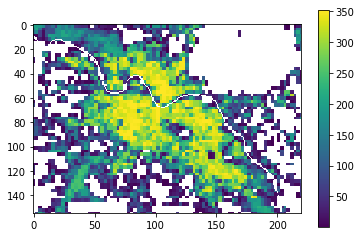

In [7]:
im = plt.imshow(array_inw_msk)
plt.colorbar(im)

In [8]:
# extra_wdepth_mask_grid = r"P:\PR\3730.10\Werkzaamheden\PR3730.15_IT\Data\Dresden\Floodscenarios (overstromingsscenarios)\floodwaterdepth_HQ2_600cm_100m.tif"
# ds_wdepth_mask = gdal.Open(extra_wdepth_mask_grid)
# band_wdepth_mask = ds_wdepth_mask.GetRasterBand(1)
# nan_wdepth_mask = band_wdepth_mask.GetNoDataValue()
# array_wdepth_mask = band_wdepth_mask.ReadAsArray()
# array_wdepth_mask = array_wdepth_mask.astype(float)
# extra_nan_mask = 0
# array_inw_msk = np.ma.masked_where(array_wdepth_mask > 600, array_inw_msk)
# array_inw_msk = np.ma.masked_where(array_wdepth_mask == extra_nan, array_inw_msk)
# nan_inh = -999.
# array_inw_msk.data[array_inw_msk.mask] = nan_inh
# im = plt.imshow(array_inw_msk.data)
# plt.title('inhabitants')
# plt.colorbar(im)
# fp_inhabitants_river_mask = r"D:\Projects\Pr\2505.12\Dresden\Floodscenarios (overstromingsscenarios)\Jan\inhabitants_100m.tif"
# saveRaster(fp_inhabitants_river_mask, array_inw_msk.data, ds_inw, datatype=6, formatraster="GTiff", nan=nan_inh)

In [9]:
for wdp_grid in wdp_grids_list:
    print(wdp_grid)
    nattevoeten_out = wdp_grid.replace('floodwaterdepth', 'flooded_settlements') 
    getroffenen_out = wdp_grid.replace('floodwaterdepth', 'affected_people')    
    victims_out = wdp_grid.replace('floodwaterdepth', 'victims')   
    compute_nattevoeten_getroffenen(inw_grid, wdp_grid, nattevoeten_out, getroffenen_out, victims_out)    

D:\Projects\Pr\2505.12\Dresden\Floodscenarios (overstromingsscenarios)\Jan\floodwaterdepth_gtHQ5_700cm_100m.tif
0.0
0.5
1.0
1.5
2.0
3.0
4.0
5.0
6.0
D:\Projects\Pr\2505.12\Dresden\Floodscenarios (overstromingsscenarios)\Jan\floodwaterdepth_HQ10_750cm_100m.tif
0.0
0.5
1.0
1.5
2.0
3.0
4.0
5.0
6.0
D:\Projects\Pr\2505.12\Dresden\Floodscenarios (overstromingsscenarios)\Jan\floodwaterdepth_HQ2_600cm_100m.tif
0.0
0.5
1.0
1.5
2.0
3.0
4.0
5.0
6.0
D:\Projects\Pr\2505.12\Dresden\Floodscenarios (overstromingsscenarios)\Jan\floodwaterdepth_ltHQ200_900cm_100m.tif
0.0
0.5
1.0
1.5
2.0
3.0
4.0
5.0
6.0
D:\Projects\Pr\2505.12\Dresden\Floodscenarios (overstromingsscenarios)\Jan\floodwaterdepth_ltHQ200_950cm_100m.tif
0.0
0.5
1.0
1.5
2.0
3.0
4.0
5.0
6.0
D:\Projects\Pr\2505.12\Dresden\Floodscenarios (overstromingsscenarios)\Jan\floodwaterdepth_ltHQ20_800cm_100m.tif
0.0
0.5
1.0
1.5
2.0
3.0
4.0
5.0
6.0
D:\Projects\Pr\2505.12\Dresden\Floodscenarios (overstromingsscenarios)\Jan\floodwaterdepth_ltHQ50_850cm_100m.t

In [ ]:
extra_wdepth_mask_grid = r"P:\PR\3730.10\Werkzaamheden\PR3730.15_IT\Data\Dresden\Floodscenarios (overstromingsscenarios)\floodwaterdepth_HQ2_600cm_100m.tif"
ds_wdepth_mask = gdal.Open(extra_wdepth_mask_grid)
band_wdepth_mask = ds_wdepth_mask.GetRasterBand(1)
nan_wdepth_mask = band_wdepth_mask.GetNoDataValue()
array_wdepth_mask = band_wdepth_mask.ReadAsArray()
array_wdepth_mask = array_wdepth_mask.astype(float)
array_wdepth_mask = np.ma.masked_where(array_wdepth_mask > 600, array_wdepth_mask)    

In [ ]:
for wdp_grid in wdp_grids_list:
    print(wdp_grid)
    
    ds_wdepth = gdal.Open(wdp_grid)
    band_wdepth = ds_wdepth.GetRasterBand(1)
    nan_wdepth = band_wdepth.GetNoDataValue()
    array_wdepth = band_wdepth.ReadAsArray()
    array_wdepth = array_wdepth.astype(float)
    array_wdepth = np.ma.masked_where(array_wdepth == nan_wdepth, array_wdepth)
    array_wdepth = np.ma.masked_where(array_wdepth_mask > 600, array_wdepth)    
    plt.imshow(array_wdepth)
    plt.show()

    array_wdepth.data[array_wdepth.mask] = nan_wdepth
    saveRaster(wdp_grid, array_wdepth, ds_wdepth, datatype=6, formatraster="GTiff", nan=nan_wdepth)

In [ ]:
extra_wdepth_mask_grid = r"P:\PR\3730.10\Werkzaamheden\PR3730.15_IT\Data\Dresden\Floodscenarios (overstromingsscenarios)\floodwaterdepth_HQ2_600cm_100m.tif"


In [ ]:
im = plt.imshow(array_wdepth_mask)

In [ ]:
ds_inw = gdal.Open(inw_grid)
band_inw = ds_inw.GetRasterBand(1)
nan_inw = band_inw.GetNoDataValue()
array_inw = band_inw.ReadAsArray()
array_inw = array_inw.astype(float)
#extra_nan = 31075
array_inw_msk = np.ma.masked_where(array_inw == nan_inw, array_inw)
#array_inw_msk = np.ma.masked_where(array_inw_msk == extra_nan, array_inw_msk)

ds_wdp = gdal.Open(wdp_grid)
band_wdp = ds_wdp.GetRasterBand(1)
nan_wdp = band_wdp.GetNoDataValue()
array_wdp = band_wdp.ReadAsArray()
array_wdp = array_wdp.astype(float)
array_wdp_msk = np.ma.masked_where(array_wdp == nan_wdp, array_wdp)    

#array_wdp_msk[array_wdp_msk > 0] = 1    

# export nattevoeten grid
#saveRaster(nattevoeten_out, array_wdp_msk.data, ds_wdp, datatype=6, formatraster="GTiff", nan=nan_wdp)    

#array_gtf_msk = array_inw_msk * array_wdp_msk
#array_gtf_msk.data[array_gtf_msk.mask] = nan_wdp

In [ ]:
im = plt.imshow(array_wdp_msk)
plt.colorbar(im)

In [ ]:
im = plt.imshow(array_gtf_msk)
plt.colorbar(im)

In [ ]:
im = plt.imshow(array_wdp_msk)
plt.colorbar(im)